In [4]:
import numpy as np
from mjx_planner import cem_planner
import mujoco.mjx as mjx 
import mujoco
import time
import jax.numpy as jnp
import jax
import os
from mujoco import viewer
import matplotlib.pyplot as plt

num_dof = 6
num_batch = 100
mpc_steps = 100

cem =  cem_planner(num_dof, num_batch)

Timestep 0.02
Default backend: gpu
JIT-compiling the model physics step...
Compilation took 0.0001659393310546875s.


/home/hurova/thesis_env/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:132: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


Target position: [-0.3  0.   0.8]


In [ ]:
pos = list()
vel = list()
costs = list()
accs = list()


rec = [0]*6
acc = [0]*6

pos.append(cem.mjx_data.qpos[:6])
vel.append(rec)
costs.append(np.linalg.norm(cem.mjx_data.xpos[cem.hande_id] - cem.target_pos))
accs.append(acc)

for step in range(mpc_steps-1):

    rec = cem.compute_cem(cem.mjx_data.qpos[:6], rec, acc)

    qvel = cem.mjx_data.qvel.at[:num_dof].set(rec)
    cem.mjx_data = cem.mjx_data.replace(qvel=qvel)

    cem.mjx_data = cem.jit_step(cem.mjx_model, cem.mjx_data)

    acc = (rec-np.array(vel)[-1])/0.02

    eef_pos = cem.mjx_data.xpos[cem.hande_id]
    cost = np.linalg.norm(eef_pos - cem.target_pos)
    pos.append(cem.mjx_data.qpos[:num_dof])
    vel.append(rec)
    costs.append(cost)
    accs.append(acc)




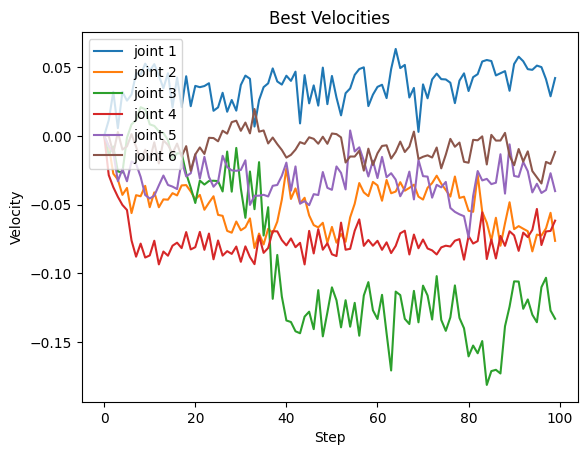

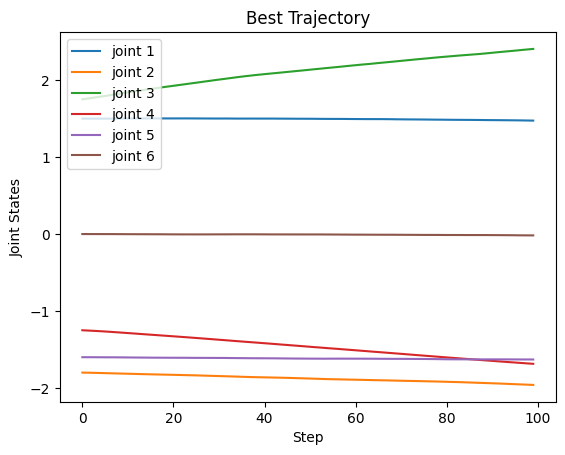

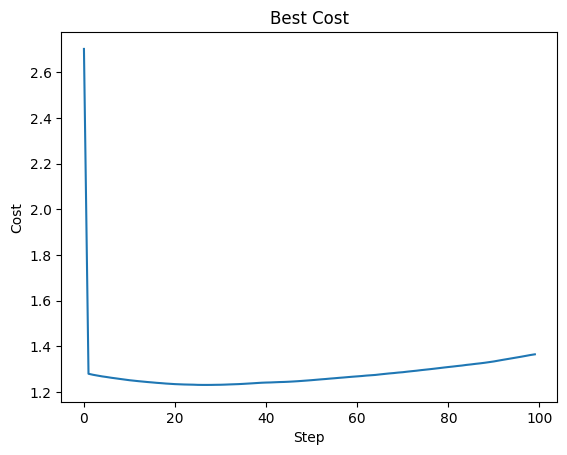

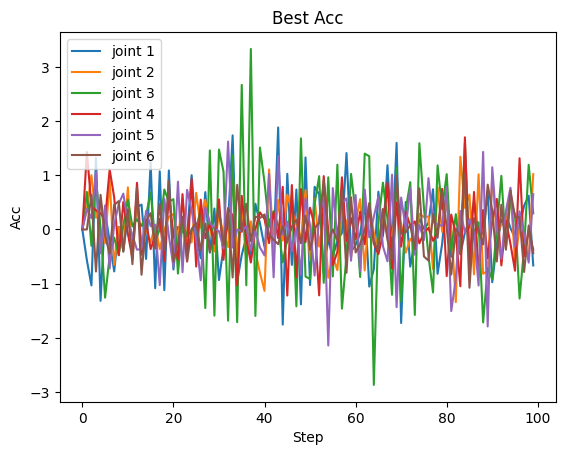

In [6]:
step = 100
plt.figure(0)
plt.plot(vel[:step])
plt.title("Best Velocities")
plt.xlabel("Step")
plt.ylabel("Velocity")
plt.legend(['joint 1', 'joint 2', 'joint 3', 'joint 4', 'joint 5', 'joint 6'], loc='upper left')
plt.show()

plt.figure(1)
plt.plot(pos[:step])
plt.title("Best Trajectory")
plt.xlabel("Step")
plt.ylabel("Joint States")
plt.legend(['joint 1', 'joint 2', 'joint 3', 'joint 4', 'joint 5', 'joint 6'], loc='upper left')
plt.show()

plt.figure(2)
plt.plot(costs[:step])
plt.title("Best Cost")
plt.xlabel("Step")
plt.ylabel("Cost")
plt.show()

plt.figure(3)
plt.plot(accs[:step])
plt.title("Best Acc")
plt.xlabel("Step")
plt.ylabel("Acc")
plt.legend(['joint 1', 'joint 2', 'joint 3', 'joint 4', 'joint 5', 'joint 6'], loc='upper left')
plt.show()


In [7]:
np.savetxt('data/best_traj.csv',pos, delimiter=",")
np.savetxt('data/best_vels.csv',vel, delimiter=",")

In [ ]:
pos = list()
vel = list()
costs = list()

model = cem.model
data = cem.data

pos.append(data.qpos[:6])
vel.append(data.qvel[:6])
# costs.append(np.linalg.norm(data.xpos[cem.hande_id] - cem.target_pos))

# qvel = cem.compute_cem(cem.mjx_data.qpos[:6], cem.mjx_data.qvel[:6])
rec = [0]*6

start = time.time()
for step in range(mpc_steps-1):
    step_start = time.time()

    rec = cem.compute_cem(data.qpos[:6], rec)

    data.qvel[:6] = rec

    mujoco.mj_step(model, data)

    # eef_pos = cem.mjx_data.xpos[cem.hande_id]
    # cost = np.linalg.norm(eef_pos - cem.target_pos)
    pos.append(data.qpos[:num_dof])
    vel.append(rec)
    # costs.append(cost)


In [ ]:
theta_init = np.tile([1.5, -1.8, 1.75, -1.25, -1.6, 0], (num_batch, 1))
# thetadot_init = np.zeros((num_batch, num_dof  ))
thetadot_init = np.tile(vel[3], (num_batch, 1))
thetaddot_init = np.zeros((num_batch, num_dof  ))
thetadot_fin = np.zeros((num_batch, num_dof  ))
thetaddot_fin = np.zeros((num_batch, num_dof  ))

state_term = np.hstack(( theta_init, thetadot_init, thetaddot_init, thetadot_fin, thetaddot_fin   ))
state_term = jnp.asarray(state_term)

maxiter_projection = 20
v_max = 0.8
a_max = 1.8
p_max = 180*np.pi/180

xi_mean = jnp.zeros(cem.nvar)
xi_cov = 5*jnp.identity(cem.nvar)

key, subkey = jax.random.split(cem.key)

xi_samples, key = cem.compute_xi_samples(key, xi_mean, xi_cov ) # xi_samples are matrix of batch times (cem.num_dof*cem.nvar_single = cem.nvar)
xi_filtered = cem.compute_projection_filter(xi_samples, state_term, maxiter_projection, v_max, a_max, p_max)
theta_batch = jnp.dot(cem.A_theta, xi_filtered.T).T 
thetadot = jnp.dot(cem.A_thetadot, xi_filtered.T).T

In [ ]:
thetadot_ = thetadot.reshape(thetadot.shape[0], num_dof, thetadot.shape[1]//num_dof)


In [ ]:
for t in thetadot_:
    plt.plot(t.T)
plt.title("Best Velocities")
plt.xlabel("Step")
plt.ylabel("Velocity")
plt.legend(['joint 1', 'joint 2', 'joint 3', 'joint 4', 'joint 5', 'joint 6'], loc='upper left')
plt.show()